In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from Utils import Utils

## No movement

### Read data
#### Read the csv files and plot them

In [5]:
data_passe_avant = Utils.read_data_csv("Passe_avant.csv")
markers_passe_avant = [
    (data_passe_avant.index[20],data_passe_avant.index[60]),
    (data_passe_avant.index[150],data_passe_avant.index[200]),
    (data_passe_avant.index[275],data_passe_avant.index[325]),
    (data_passe_avant.index[500],data_passe_avant.index[540]),
    (data_passe_avant.index[650],data_passe_avant.index[690]),
    (data_passe_avant.index[850],data_passe_avant.index[890]),
]

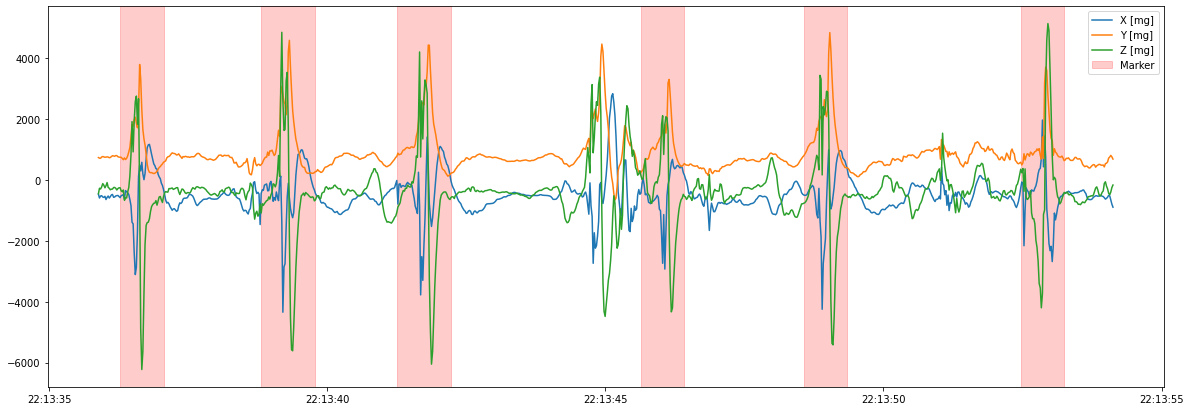

In [6]:
Utils.plot_with_markers(data_passe_avant,markers_passe_avant)

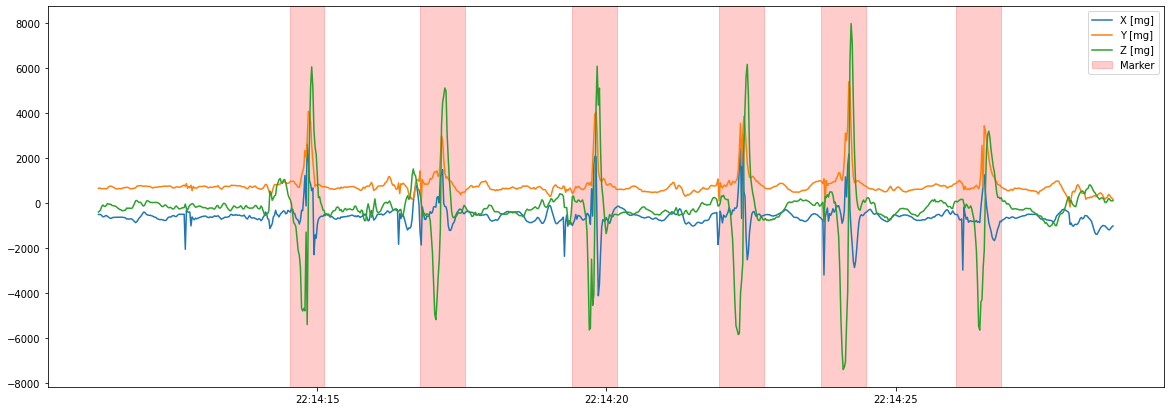

In [7]:
data_passe_backend = Utils.read_data_csv("Passe_backend.csv")
markers_passe_backend = [
    (data_passe_backend.index[170],data_passe_backend.index[200]),
    (data_passe_backend.index[285],data_passe_backend.index[325]),
    (data_passe_backend.index[420],data_passe_backend.index[460]),
    (data_passe_backend.index[550],data_passe_backend.index[590]),
    (data_passe_backend.index[640],data_passe_backend.index[680]),
    (data_passe_backend.index[760],data_passe_backend.index[800]),
]
Utils.plot_with_markers(data_passe_backend,markers_passe_backend)

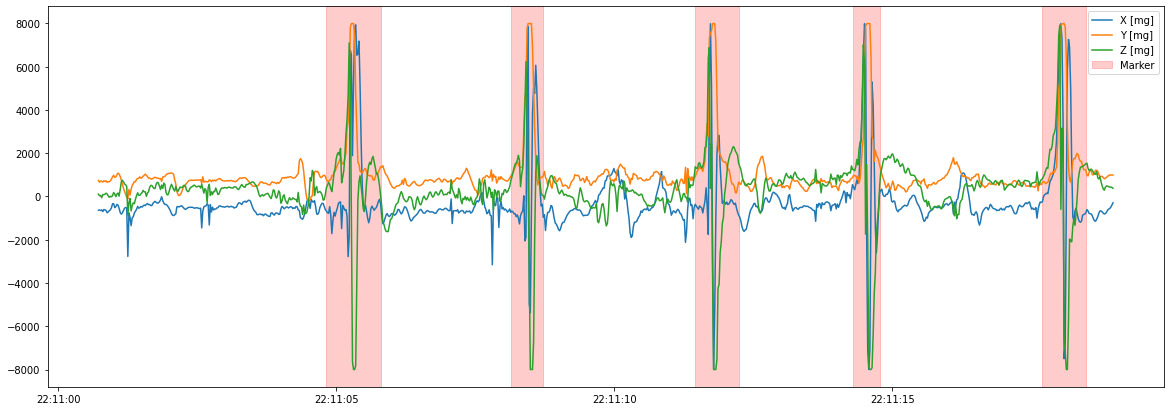

In [8]:
data_tir_avant = Utils.read_data_csv("Tir_avant.csv")
markers_tir_avant = [
    (data_tir_avant.index[210],data_tir_avant.index[260]),
    (data_tir_avant.index[380],data_tir_avant.index[410]),
    (data_tir_avant.index[550],data_tir_avant.index[590]),
    (data_tir_avant.index[695],data_tir_avant.index[720]),
    (data_tir_avant.index[870],data_tir_avant.index[910]),
]
Utils.plot_with_markers(data_tir_avant,markers_tir_avant)

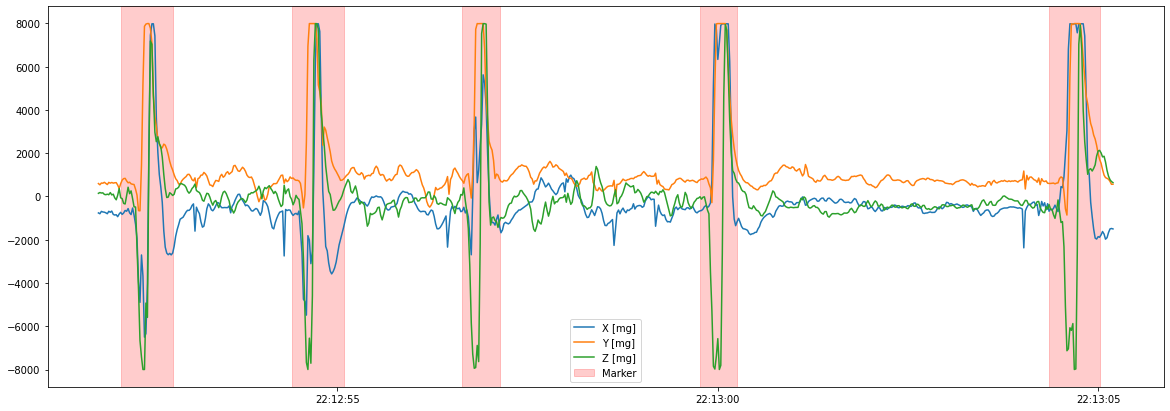

In [9]:
data_tir_backend = Utils.read_data_csv("Tir_backend.csv")
markers_tir_backend = [
    (data_tir_backend.index[15],data_tir_backend.index[50]),
    (data_tir_backend.index[130],data_tir_backend.index[165]),
    (data_tir_backend.index[245],data_tir_backend.index[270]),
    (data_tir_backend.index[405],data_tir_backend.index[430]),
    (data_tir_backend.index[640],data_tir_backend.index[-10]),
]
Utils.plot_with_markers(data_tir_backend,markers_tir_backend)

In [10]:
data_backend,markers_backend = Utils.concatenate_data(data_tir_backend.copy(),data_passe_backend.copy(),markers_tir_backend,markers_passe_backend)
data_avant,markers_avant = Utils.concatenate_data(data_tir_avant.copy(),data_passe_avant.copy(),markers_tir_avant,markers_passe_avant)

In [11]:
#data,markers = concatenate_data(data_tir_backend.copy(),data_passe_backend.copy(),markers_tir_backend,markers_passe_backend)
#plot_with_markers_label(data,markers)

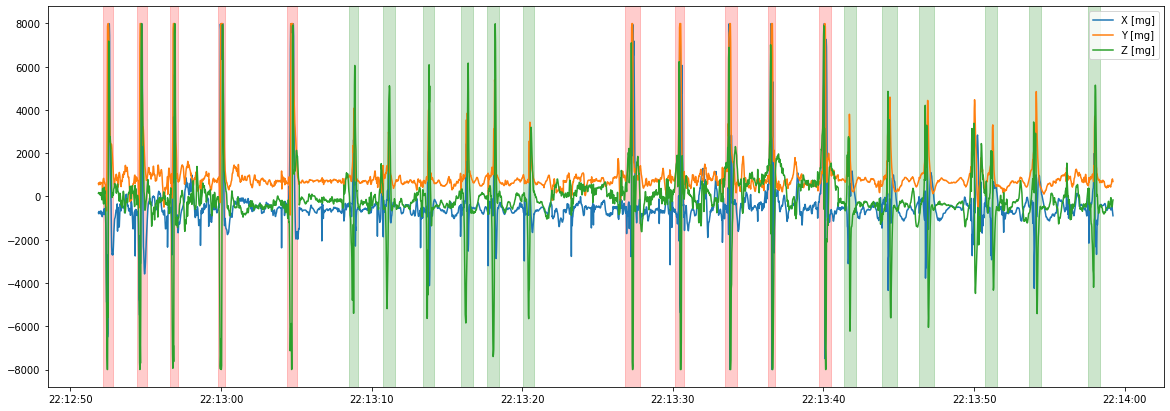

In [12]:
data,markers = Utils.concatenate_data_bis(data_backend.copy(),data_avant.copy(),markers_backend,markers_avant)
Utils.plot_with_markers_label(data,markers)

In [13]:
y_real = Utils.add_column_classification(data,markers)
y_real.shape

(3456,)

In [14]:
freq_sampling = 50

In [15]:
def compute_features(block):
    norms = np.linalg.norm(block,axis=1)
    return np.array([np.abs(np.max(norms)-np.min(norms)),np.max(norms),np.quantile(norms,0.25)])

In [16]:
def window_slide(data:pd.DataFrame,y,window_size):
    dataset = data.values
    n = len(data)//window_size
    features_extracted = []
    y_block = np.zeros(n)
    for i in range(n):
        block = dataset[i*window_size:(i+1)*window_size]
        features = compute_features(block)
        features_extracted.append(features)
        y_block[i] = Utils.get_label(y[i*window_size:(i+1)*window_size])
    return np.array(features_extracted),y_block

In [17]:
def box_plot(data,y,window_size,labels=['idk','shoot','pass']):
    dataset = data.values
    n = len(data)//window_size
    features_extracted = []
    blocks = {u:[] for u in np.unique(y)}
    for i in range(n):
        block = dataset[i*window_size:(i+1)*window_size]
        blocks[y[i]].append(block)
    
    data_box = []
    for label in blocks.keys():
        norms = []
        for block in blocks[label]:
            norms.append(np.linalg.norm(block,axis=1))
        
        norms = np.concatenate(norms)
        data_box.append(norms)

    fig,ax = plt.subplots(figsize=(10,7))
    ax.boxplot(data_box)
    ax.set_xticks(np.arange(1,len(blocks.keys())+1))
    ax.set_xticklabels(labels)
    plt.show()

In [18]:
markers_timedelta_max=np.max([end-start for (start,end,_) in markers])//(1.8)
window_size=int(markers_timedelta_max.total_seconds()*freq_sampling)
window_size

27

In [19]:
def plot_data_y(data,y,window_size):
    fig,ax = plt.subplots(figsize=(15,7))
    ax.plot(data.values)
    for i in range(len(y)):
        if y[i]!=0:
            ax.axvspan(i*window_size,(i+1)*window_size,color='r'if y[i]==1 else 'g',alpha=0.2)
    

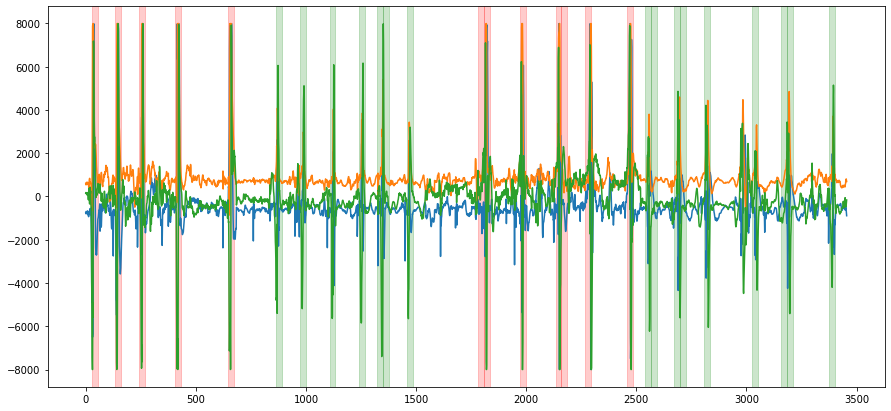

In [20]:
X,y = window_slide(data,y_real,window_size)
y.shape
plot_data_y(data,y,window_size)

In [21]:
def add_samples_shoot_pass(X,y,n,add_noise=True):
    idx_shoot = np.argwhere(y==1)
    idx_pass = np.argwhere(y==2)

    idx_shoot = np.repeat(idx_shoot,n)
    idx_pass = np.repeat(idx_pass,n)

    idx_shoot = idx_shoot[np.random.choice(idx_shoot.shape[0],n,replace=False)]
    idx_pass = idx_pass[np.random.choice(idx_pass.shape[0],n,replace=False)]

    new_X = np.zeros((X.shape[0]+2*n,X.shape[1]))
    new_y = np.zeros(X.shape[0]+2*n)

    new_X[:X.shape[0],:] = X[:,:].copy()
    new_y[:X.shape[0]] = y[:].copy()

    new_X[X.shape[0]:X.shape[0]+n,:] = X[idx_shoot,:] + np.random.normal(10,100,size=[n,X.shape[1]]) if add_noise else 0.
    new_X[X.shape[0]+n:,:] = X[idx_pass,:]  + np.random.normal(10,100,size=[n,X.shape[1]]) if add_noise else 0.

    new_y[X.shape[0]:X.shape[0]+n] = 1
    new_y[X.shape[0]+n:] = 2

    return new_X, new_y
        

In [22]:
X,y = add_samples_shoot_pass(X,y,n=15,add_noise=True)

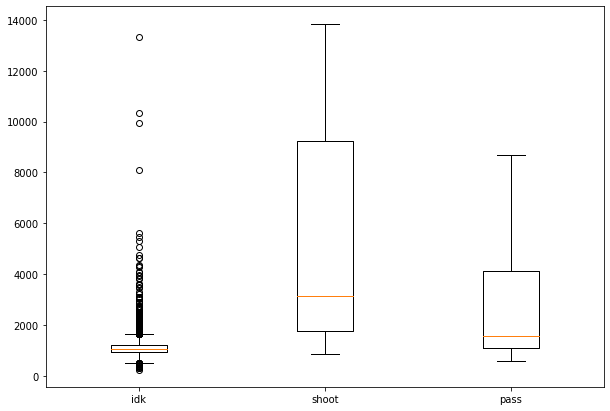

In [23]:
box_plot(data,y,window_size)

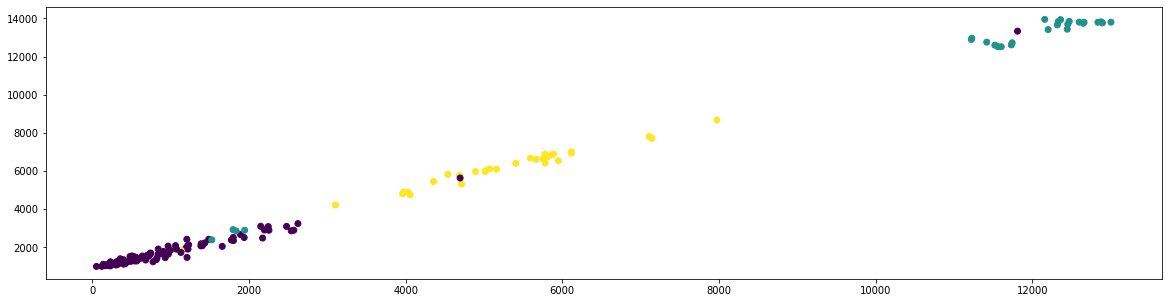

In [27]:
# Quick plot to see if we can separate the data for machine learning 
fig,ax = plt.subplots(figsize=(20,5))
ax.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [31]:
#%matplotlib qt

#fig = plt.figure(figsize=(20,7))
#ax = fig.add_subplot(projection='3d')

#ax.scatter(X[:,0],X[:,1],X[:,2],c=y)

#plt.show()

In [ ]:
%matplotlib inline

## Classifiers

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn import metrics

In [29]:
X.shape

(158, 3)

In [30]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33)

### Logistic Regression

In [ ]:
clf = LogisticRegression()
clf.fit(X_train,y_train)

LogisticRegression()

<AxesSubplot:>

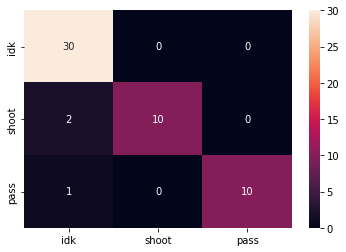

In [ ]:
labels = ['idk','shoot','pass']
y_pred_test=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)
sn.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels)

In [ ]:
print(f'Accuracy with test data : {metrics.accuracy_score(y_test, y_pred_test)}')

Accuracy with test data : 0.9433962264150944


<AxesSubplot:>

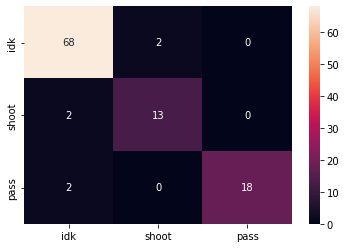

In [ ]:
y_pred_train=clf.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)
sn.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels)

In [ ]:
print(f'Accuracy with train data : {metrics.accuracy_score(y_train, y_pred_train)}')

Accuracy with train data : 0.9428571428571428


### KNN

In [ ]:
clf = KNeighborsClassifier()
clf.fit(X_train,y_train)

KNeighborsClassifier()

<AxesSubplot:>

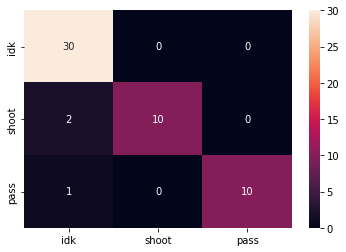

In [ ]:
y_pred_test=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)
sn.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels)

In [ ]:
print(f'Accuracy with test data : {metrics.accuracy_score(y_test, y_pred_test)}')

Accuracy with test data : 0.9433962264150944


<AxesSubplot:>

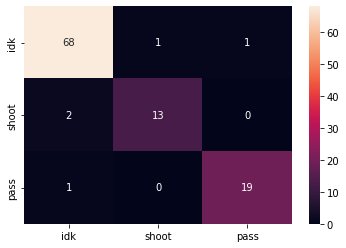

In [ ]:
y_pred_train=clf.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)
sn.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels)

In [ ]:
print(f'Accuracy with train data : {metrics.accuracy_score(y_train, y_pred_train)}')

Accuracy with train data : 0.9523809523809523


## Data with movement

In [ ]:
data_shoot_moving = Utils.read_data_csv('DATA_NEW/SHOOT_AVANT.csv')
markers_shoot_moving = Utils.read_markers('DATA_NEW/MARKER_SHOOT_AVANT.csv')
markers_shoot_moving

[(Timestamp('2021-12-07 21:17:35.555000'),
  Timestamp('2021-12-07 21:17:37.555000')),
 (Timestamp('2021-12-07 21:17:40.554000'),
  Timestamp('2021-12-07 21:17:43.295000')),
 (Timestamp('2021-12-07 21:17:46.991000'),
  Timestamp('2021-12-07 21:17:49.383000')),
 (Timestamp('2021-12-07 21:17:52.615000'),
  Timestamp('2021-12-07 21:17:55.086000')),
 (Timestamp('2021-12-07 21:17:57.496000'),
  Timestamp('2021-12-07 21:17:59.900000')),
 (Timestamp('2021-12-07 21:18:06.125000'),
  Timestamp('2021-12-07 21:18:09.940000')),
 (Timestamp('2021-12-07 21:18:11.790000'),
  Timestamp('2021-12-07 21:18:16.822000')),
 (Timestamp('2021-12-07 21:18:17.493000'),
  Timestamp('2021-12-07 21:18:21.538000')),
 (Timestamp('2021-12-07 21:18:27.044000'),
  Timestamp('2021-12-07 21:18:29.480000')),
 (Timestamp('2021-12-07 21:18:35.591000'),
  Timestamp('2021-12-07 21:18:38.148000')),
 (Timestamp('2021-12-07 21:18:40.107000'),
  Timestamp('2021-12-07 21:18:42.393000'))]

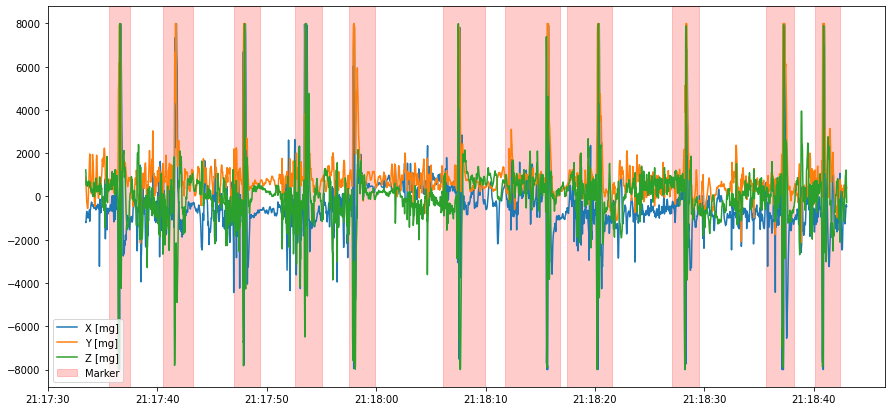

In [ ]:
Utils.plot_with_markers(data_shoot_moving,markers_shoot_moving)

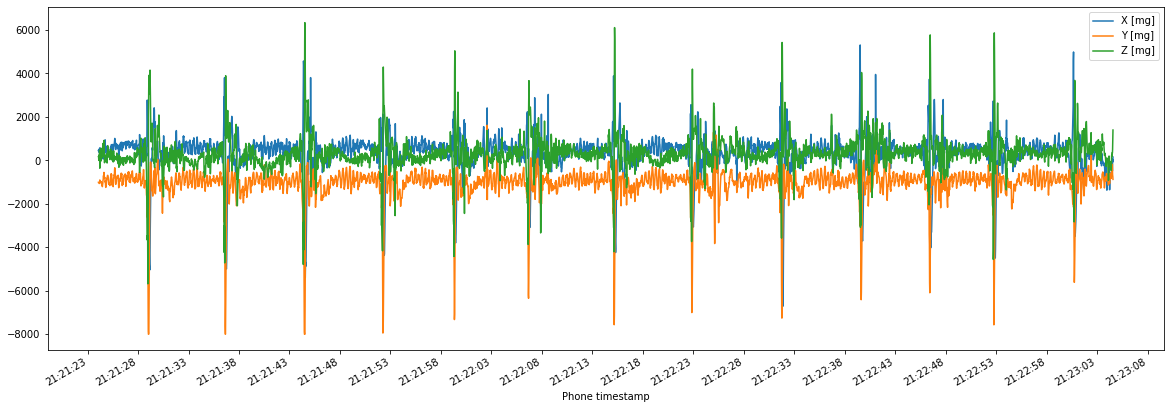

In [ ]:
data_pass_moving = Utils.read_data_csv('DATA_NEW/PASSE_AVANT_THOMAS.csv')
ax = data_pass_moving.plot(figsize=(20,7))
ax.xaxis.set_major_locator(mdates.SecondLocator(interval=5))
plt.show()

In [ ]:
markers_pass_moving = Utils.read_markers('DATA_NEW/MARKER_PASS_AVANT.csv')

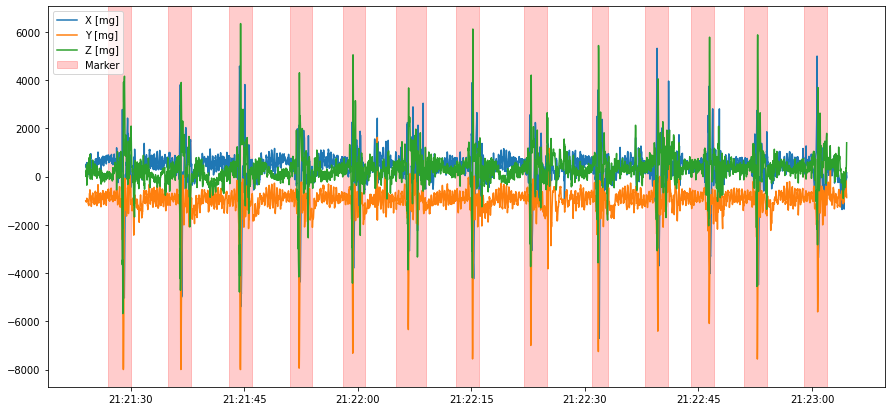

In [ ]:
Utils.plot_with_markers(data_pass_moving,markers_pass_moving)

In [ ]:
data_moving,markers_moving = data_backend,markers_backend = Utils.concatenate_data(data_shoot_moving.copy(),data_pass_moving.copy(),markers_shoot_moving,markers_pass_moving)

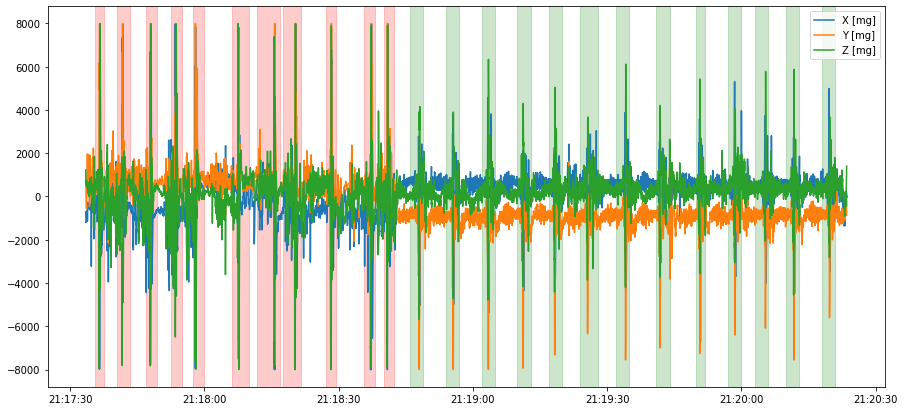

In [ ]:
Utils.plot_with_markers_label(data_moving,markers_moving)

In [ ]:
y_real_moving = Utils.add_column_classification(data_moving,markers_moving)
y_real_moving.shape

(8712,)

In [ ]:
markers_timedelta_max=np.max([end-start for (start,end,_) in markers_moving])//(1.8)
window_size=int(markers_timedelta_max.total_seconds()*freq_sampling)
window_size

139

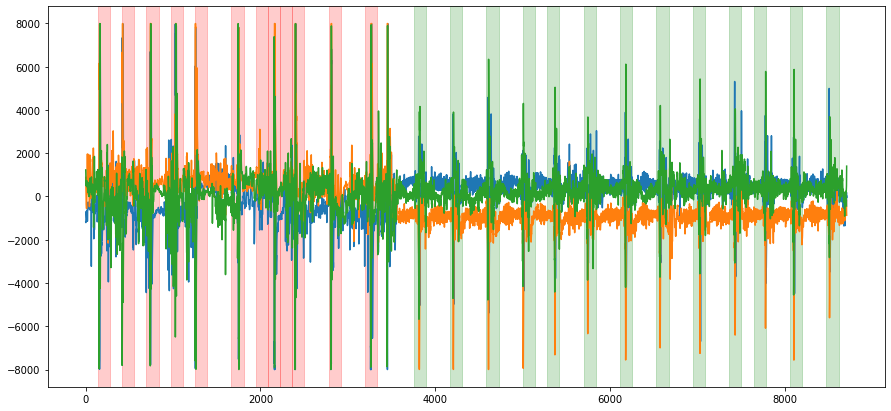

In [ ]:
X,y = window_slide(data_moving,y_real_moving,window_size)
plot_data_y(data_moving,y,window_size)

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.45)

[Logistic Regression] Accuracy with train data : 0.8823529411764706
[Logistic Regression] Accuracy with test data : 0.7857142857142857
[Logistic Regression] Number of shoots detected : 10
[Logistic Regression] Number of passes detected : 12


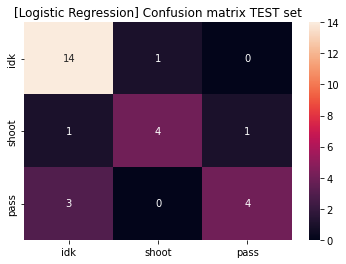

In [ ]:
# Logistic Regression
clf = LogisticRegression()
clf.fit(X_train,y_train)

y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

ax = plt.axes()
sn.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels,ax=ax)
ax.set_title('[Logistic Regression] Confusion matrix TEST set')

print(f'[Logistic Regression] Accuracy with train data : {metrics.accuracy_score(y_train, y_pred_train)}')
print(f'[Logistic Regression] Accuracy with test data : {metrics.accuracy_score(y_test, y_pred_test)}')

n_shoot_detected = len(y_pred_train[y_pred_train==1])+len(y_pred_test[y_pred_test==1])
n_pass_detected = len(y_pred_train[y_pred_train==2])+len(y_pred_test[y_pred_test==2])
print(f'[Logistic Regression] Number of shoots detected : {n_shoot_detected}')
print(f'[Logistic Regression] Number of passes detected : {n_pass_detected}')

[KNeighbors Classifier] Accuracy with train data : 0.8529411764705882
[KNeighbors Classifier] Accuracy with test data : 0.8928571428571429
[KNeighbors Classifier] Number of shoots detected : 12
[KNeighbors Classifier] Number of passes detected : 14


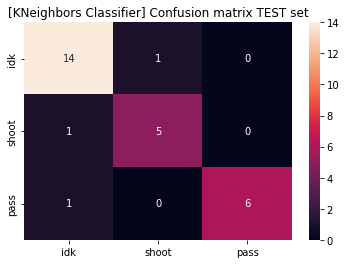

In [ ]:
# KNeighbors Classifier
clf = KNeighborsClassifier()
clf.fit(X_train,y_train)

y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

ax = plt.axes()
sn.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels,ax=ax)
ax.set_title('[KNeighbors Classifier] Confusion matrix TEST set')

print(f'[KNeighbors Classifier] Accuracy with train data : {metrics.accuracy_score(y_train, y_pred_train)}')
print(f'[KNeighbors Classifier] Accuracy with test data : {metrics.accuracy_score(y_test, y_pred_test)}')

n_shoot_detected = len(y_pred_train[y_pred_train==1])+len(y_pred_test[y_pred_test==1])
n_pass_detected = len(y_pred_train[y_pred_train==2])+len(y_pred_test[y_pred_test==2])
print(f'[KNeighbors Classifier] Number of shoots detected : {n_shoot_detected}')
print(f'[KNeighbors Classifier] Number of passes detected : {n_pass_detected}')

### Match

<AxesSubplot:xlabel='Phone timestamp'>

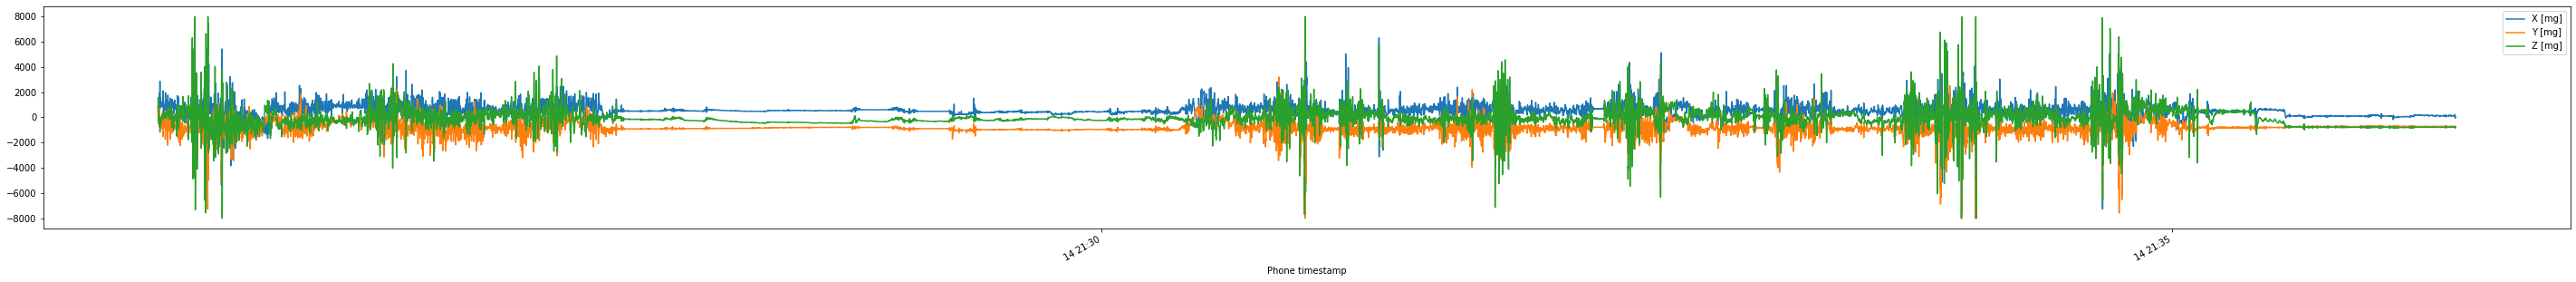

In [ ]:
df_match = Utils.read_data_csv('MATCH\Match_partie1.csv')
df_match.plot(figsize=(50,5))